In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2 as cv
from google.colab import drive

In [12]:
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
train_dir = "/content/drive/MyDrive/train"
test_dir = "/content/drive/MyDrive/test"

In [14]:

class_names = ['Lumpy Skin', 'Normal Skin']

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

train_gen = train_datagen.flow_from_directory(train_dir, target_size=(256, 256), batch_size=3, classes=class_names)
val_gen = test_datagen.flow_from_directory(test_dir, target_size=(256, 256), batch_size=1, classes=class_names)


Found 1034 images belonging to 2 classes.
Found 1024 images belonging to 2 classes.


In [15]:
inputs = keras.Input(shape=[256, 256, 3])

convo1 = keras.layers.Conv2D(128, kernel_size=(3, 3), padding="same", activation='relu', use_bias=True)(inputs)
convo1_pooling = keras.layers.MaxPooling2D((2, 2))(convo1)

convo2 = keras.layers.Conv2D(64, (3, 3), activation='relu', use_bias=True)(convo1_pooling)
convo2_pooling = keras.layers.MaxPooling2D((2, 2))(convo2)

convo3 = keras.layers.Conv2D(32, (3, 3), activation='relu', use_bias=True)(convo2_pooling)
convo3_pooling = keras.layers.MaxPooling2D((2, 2))(convo3)

convo4 = keras.layers.Conv2D(128, (3, 3), activation='relu', use_bias=True, kernel_regularizer=keras.regularizers.l2(l=0.001))(convo3_pooling)
convo4_pooling = keras.layers.MaxPooling2D((2, 2))(convo4)

flatten = keras.layers.Flatten()(convo4_pooling)

hidden1 = keras.layers.Dense(256, activation='relu')(flatten)
hidden2 = keras.layers.Dense(128, activation='relu')(hidden1)
hidden3 = keras.layers.Dense(64, activation='relu')(hidden2)
concat_1 = keras.layers.Concatenate()([hidden1, hidden3])
hidden4 = keras.layers.Dense(32, activation='relu')(concat_1)
hidden5 = keras.layers.Dense(64, activation='relu')(hidden4)
concat_2 = keras.layers.Concatenate()([hidden4, hidden5])
hidden6 = keras.layers.Dense(128, activation='relu')(concat_2)
concat_3 = keras.layers.Concatenate()([hidden2, hidden6])
hidden7 = keras.layers.Dense(64, activation='relu')(concat_3)
hidden8 = keras.layers.Dense(32, activation='relu')(hidden7)
output = keras.layers.Dense(2, activation='softmax')(hidden8)  # Number of output units matches the number of classes
model = keras.models.Model(inputs=[inputs], outputs=[output])


In [16]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 256, 256, 128)        3584      ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 128, 128, 128)        0         ['conv2d_4[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_5 (Conv2D)           (None, 126, 126, 64)         73792     ['max_pooling2d_4[0][0]'

In [17]:
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['acc'])

In [18]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("Bestmodel.h5", save_best_only=True)

In [19]:
early_stop = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)


In [20]:
model_history = model.fit(train_gen, steps_per_epoch=30, epochs=100, validation_data=val_gen, validation_steps=15, callbacks=[checkpoint_cb])

Epoch 1/100
30/30 [==============================] - 69s 2s/step - loss: 2.7051 - acc: 0.5222 - val_loss: 0.8468 - val_acc: 0.6667


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/100
30/30 [==============================] - 41s 1s/step - loss: 0.6505 - acc: 0.7333 - val_loss: 0.9844 - val_acc: 0.5333
Epoch 3/100
30/30 [==============================] - 42s 1s/step - loss: 0.7358 - acc: 0.6778 - val_loss: 0.4441 - val_acc: 0.8667
Epoch 4/100
30/30 [==============================] - 41s 1s/step - loss: 0.6681 - acc: 0.7333 - val_loss: 0.4699 - val_acc: 0.7333
Epoch 5/100
30/30 [==============================] - 40s 1s/step - loss: 0.6128 - acc: 0.7667 - val_loss: 0.9191 - val_acc: 0.4000
Epoch 6/100
30/30 [==============================] - 40s 1s/step - loss: 0.6906 - acc: 0.7000 - val_loss: 0.4537 - val_acc: 0.8667
Epoch 7/100
30/30 [==============================] - 41s 1s/step - loss: 0.5157 - acc: 0.8000 - val_loss: 0.3253 - val_acc: 0.8000
Epoch 8/100
30/30 [==============================] - 42s 1s/step - loss: 0.5082 - acc: 0.7778 - val_loss: 0.4867 - val_acc: 0.8667
Epoch 9/100
30/30 [==============================] - 42s 1s/step - loss: 0.6093 - a

(0.0, 1.0)

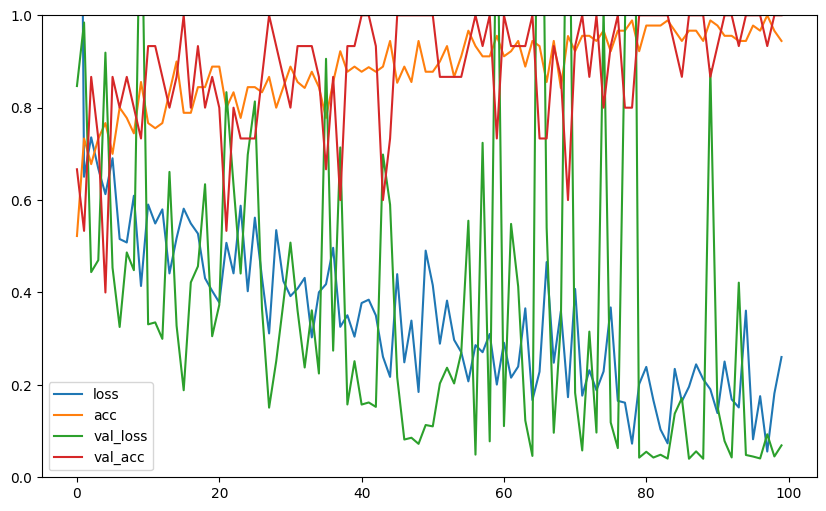

In [22]:
pd.DataFrame(model_history.history).plot(figsize=[10, 6])
plt.gca().set_ylim(0, 1)

In [52]:
model.save('widen.h5')


In [53]:
model = keras.models.load_model('widen.h5')

In [81]:
image = cv.imread('/content/drive/MyDrive/test/Normal Skin/Normal_Skin_194.png')

In [82]:
image.shape

(256, 256, 3)

In [83]:
from google.colab.patches import cv2_imshow

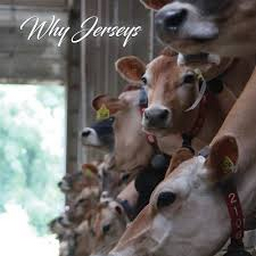

In [84]:
cv2_imshow(image)

In [85]:
def crop_resize(img):
  image_1_resize = cv.resize(img,(256,256))
  return image_1_resize

In [86]:
image=crop_resize(image)
image.shape

(256, 256, 3)

In [87]:
disease_info = {
    'Lumpy Skin': '''
        Description: "Lumby Skin" is a dermatological condition characterized by the presence of lumby patches or areas on the skin. These patches may appear discolored, raised, or textured differently from the surrounding skin.
        Possible Causes: The causes of Lumby Skin can vary and may include fungal infections, allergic reactions, autoimmune disorders, or other skin conditions.
        Treatment: Treatment for Lumby Skin depends on the underlying cause. It may involve antifungal medications, topical steroids, moisturizers, or other dermatological treatments as per the diagnosis.
    ''',
    'Normal Skin': '''
        Description: "Normal skin" refers to skin that is healthy, without any significant abnormalities or conditions. It typically appears smooth, evenly colored, and free from notable blemishes or irregularities.
        Possible Causes: Normal skin is maintained through proper skincare routines, hydration, balanced nutrition, and overall good health practices.
        Treatment: As normal skin is not afflicted by any particular condition, treatment primarily involves maintaining good skincare habits, protecting the skin from environmental damage, and addressing any minor issues promptly to prevent them from becoming problematic.
    '''
}

In [88]:
image = tf.expand_dims(image, axis=0)
image.shape.as_list()

[1, 256, 256, 3]

In [89]:
yproba = model.predict(image)
yproba

1/1 [==============================] - 0s 135ms/step


array([[0.01898437, 0.9810157 ]], dtype=float32)

In [90]:
class_name=class_names[np.argmax(yproba,axis=1)[0]]

In [91]:
predicted_disease_info = disease_info.get(class_name, 'No information available for the predicted disease.')


In [92]:
print(f"Predicted Disease: {class_name}")
print(predicted_disease_info)

Predicted Disease: Normal Skin

        Description: "Normal skin" refers to skin that is healthy, without any significant abnormalities or conditions. It typically appears smooth, evenly colored, and free from notable blemishes or irregularities.
        Possible Causes: Normal skin is maintained through proper skincare routines, hydration, balanced nutrition, and overall good health practices.
        Treatment: As normal skin is not afflicted by any particular condition, treatment primarily involves maintaining good skincare habits, protecting the skin from environmental damage, and addressing any minor issues promptly to prevent them from becoming problematic.
    
